# Bilinear Interpolation

linear함수의 특징을 사용해 image의 사이즈를 줄이거나 늘려보자

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## my_bilinear

In [2]:
def my_bilinear(src, dst_shape):

    (src_h, src_w) = src.shape
    (dst_h, dst_w) = dst_shape

    dst = np.zeros((dst_h, dst_w), dtype = np.uint8)

    scale_h = dst_h/src_h
    scale_w = dst_w/src_w
    
     # bilinear()적용하기

    for h in range(dst_h):
        for w in range(dst_w):

            if h%scale_h==0 and w%scale_w==0:
                dst[int(h), int(w)] = src[int(h/scale_h), int(w/scale_w)]

            else:
                # 1-s
                A = (scale_w - (w%scale_w))/scale_w
                # 1-t
                B = (scale_h - (h%scale_h))/scale_h
                # s
                C = (w%scale_w)/scale_w
                # t
                D = (h%scale_h)/scale_h

                # upsampling의 오른쪽 끝과 아래쪽 끝 부분은 값이 0임
                # ex. 512x512 에서 맨 끝은 511이기 때문에 0을 가지고 이 값으로 아래식을 사용하면 out of index 발생
                if h >= (src_h-1)*scale_h and w < (src_h-1)*scale_w:
                    dst[h,w] = (A*B)*src[int(h/scale_h), int(w/scale_w)] + (C*B)*src[int(h/scale_h), int(w/scale_w) + 1] + (A*D)*src[int(h/scale_h), int(w/scale_w)] + (C*D)*src[int(h/scale_h), int(w/scale_w) + 1]

                elif h < (src_h - 1) * scale_h and w >= (src_h - 1) * scale_w:
                    dst[h, w] = (A * B) * src[int(h / scale_h), int(w / scale_w)] + (C * B) * src[int(h / scale_h), int(w / scale_w)] + (A * D) * src[int(h / scale_h)+1, int(w / scale_w)] + (C * D) * src[int(h / scale_h)+1, int(w / scale_w)]

                elif h >= (src_h - 1) * scale_h and w >= (src_h - 1) * scale_w:
                    dst[h, w] = (A * B) * src[int(h / scale_h), int(w / scale_w)] + (C * B) * src[int(h / scale_h), int(w / scale_w)] + (A * D) * src[int(h / scale_h), int(w / scale_w)] + (C * D) * src[int(h / scale_h), int(w / scale_w)]

                else:
                    dst[h,w] = (A*B)*src[int(h/scale_h), int(w/scale_w)] + (C*B)*src[int(h/scale_h), int(w/scale_w) + 1] + (A*D)*src[int(h/scale_h) + 1, int(w/scale_w)] + (C*D)*src[int(h/scale_h) + 1, int(w/scale_w) + 1]


    return dst

기존 이미지를 src, 바꾸고 싶은 이미지 size를 dst에 넣어 원본이미지를 dst에 맞게 바꿔주는 함수입니다.
scale = dst / src를 통해 원본 이미지에 몇 배 할지 알아내고, 그 배수만큼은 원본이미지에서 그대로 가져갑니다.
그리고 남은 pixel에 대해서는 bilinear식을 사용하여 채워줍니다.

* 그림의 끝으로 가면 out of index가 발생하기 때문에 예외처리를 해주어야합니다.

# compare_img

In [3]:
def compare_img_bilinear(src, dst1_shape, dst2_shape):
    
    fig, ax = plt.subplots(1,3, figsize = (16,9))
    
    ax[0].set_title('original')
    ax[0].imshow(cv2.cvtColor(src,cv2.COLOR_GRAY2RGB))
    
    #downsampling
    
    ax[1].set_title('my bilinear mini'+str(dst1_shape))
    ax[1].imshow(cv2.cvtColor(my_bilinear(src, dst1_shape), cv2.COLOR_GRAY2RGB))

    #upsampling
    
    ax[2].set_title('my bilinear'+str(dst2_shape))
    ax[2].imshow(cv2.cvtColor(my_bilinear(my_bilinear(src, dst1_shape), dst2_shape), cv2.COLOR_GRAY2RGB))
    plt.show()
    print(" ")

## 비교

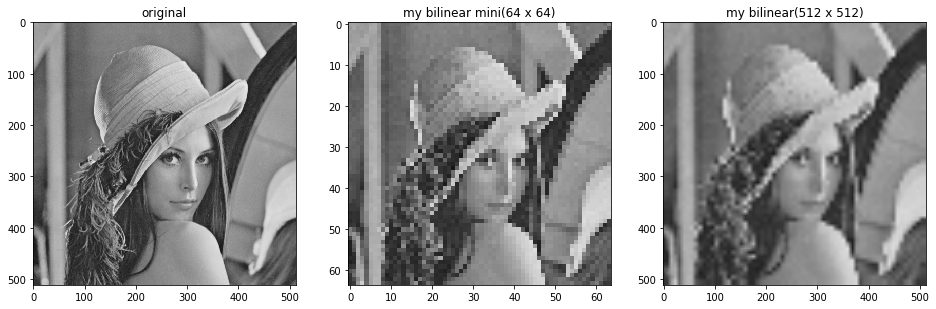

In [4]:

src = cv2.imread('Lena.png', cv2.IMREAD_GRAYSCALE)

#이미지 크기 64x64로 변경
my_dst_mini = my_bilinear(src, (64, 64))

#이미지 크기 512x512로 변경(Lena.png 이미지의 shape는 (512, 512))
my_dst = my_bilinear(my_dst_mini, (512, 512))

fig, ax = plt.subplots(1,3, figsize = (16,9))

ax[0].set_title('original')
ax[0].imshow(cv2.cvtColor(src, cv2.COLOR_GRAY2RGB))


ax[1].set_title('my bilinear mini(64 x 64)')
ax[1].imshow(cv2.cvtColor(my_dst_mini, cv2.COLOR_GRAY2RGB))


ax[2].set_title('my bilinear(512 x 512)')
ax[2].imshow(cv2.cvtColor(my_dst, cv2.COLOR_GRAY2RGB))
plt.show()


512 x 512 원본 이미지를 64 x 64로 downsampling 후 다시 512 x 512 로 upsampling 했습니다. 첫번째와 세번째 사진을 비교해보면 완벽히 복구하지 못했습니다. downsampling 한 image에 따라 어떻게 복구가 되는지 알아보는 시간을 가져봅시다.

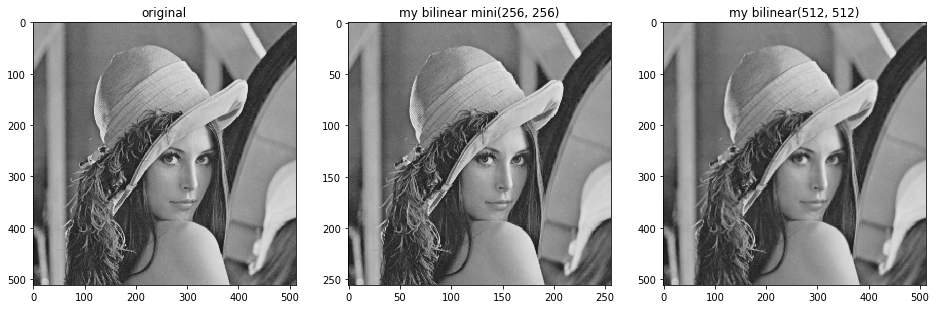

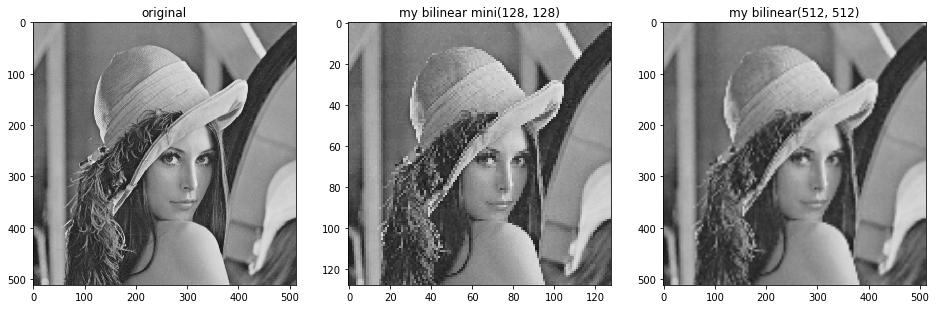

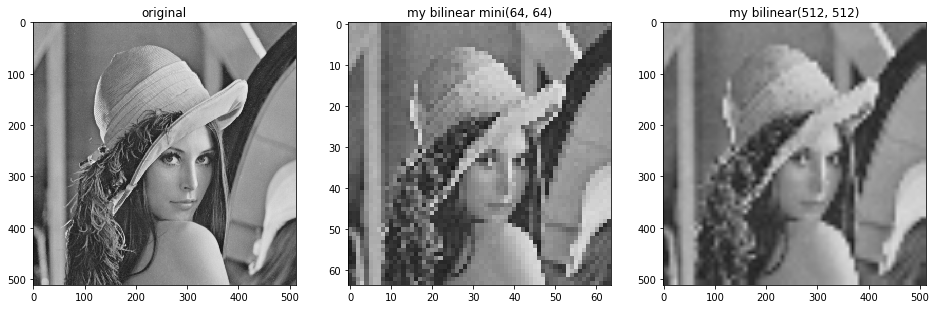

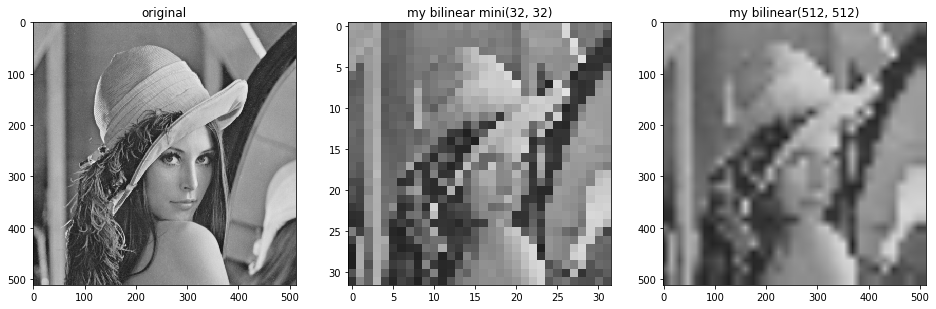

In [5]:
compare_img_bilinear(src, (256,256),(512,512))

compare_img_bilinear(src, (128,128),(512,512))

compare_img_bilinear(src, (64,64),(512,512))

compare_img_bilinear(src, (32,32),(512,512))

512 x 512 img를 위에서부터 256, 128, 64, 32 로 downsampling 후 512로 upsampling 하는 과정을 거쳤습니다. 
위 사진을 보면 더 작은 image로 downsampling 할수록 원본으로 복원시키기 어려운 것을 알 수 있습니다.

# nearest_neighbor interpolation

downsampling이나 upsampling시 가까운 위치의 pixel을 끌어서 사용하는 nearest_neighbor interpoliation을 만들어보자

## my_nearest_neighbor

In [6]:
def my_nearest_neighbor(src, scale):
    (h,w) = src.shape
    h_dst = int(h * scale + 0.5)
    w_dst = int(w * scale + 0.5)
    
    dst = np.zeros((h_dst, w_dst), np.uint8)
    for row in range(h_dst):
        for col in range(w_dst):
            r = min(int(row / scale + 0.5), h-1)
            c = min(int(col / scale + 0.5), w-1)
            dst[row, col] = src[r, c]
            
    return dst

## compare_img_nearest

In [7]:
def compare_img_nearest(src, dst1_shape, dst2_shape):
    
    fig, ax = plt.subplots(1,3, figsize = (16,9))
    
    ax[0].set_title('original')
    ax[0].imshow(cv2.cvtColor(src,cv2.COLOR_GRAY2RGB))
    
    #downsampling
    
    ax[1].set_title('my nearest mini'+str(my_nearest_neighbor(src, dst1_shape).shape))
    ax[1].imshow(cv2.cvtColor(my_nearest_neighbor(src, dst1_shape), cv2.COLOR_GRAY2RGB))

    #upsampling
    
    ax[2].set_title('my nearest'+str(my_nearest_neighbor(my_nearest_neighbor(src, dst1_shape), dst2_shape).shape))
    ax[2].imshow(cv2.cvtColor(my_nearest_neighbor(my_nearest_neighbor(src, dst1_shape), dst2_shape), cv2.COLOR_GRAY2RGB))
    plt.show()
    print(" ")

## 비교

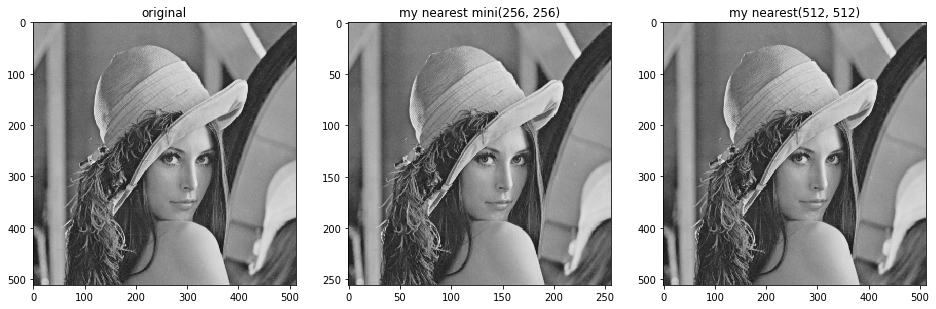

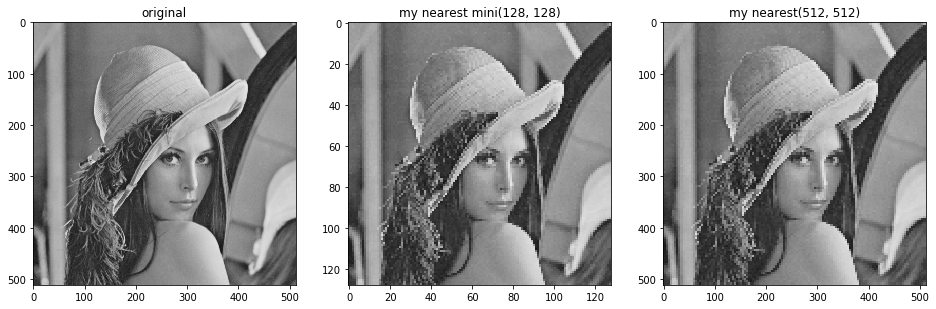

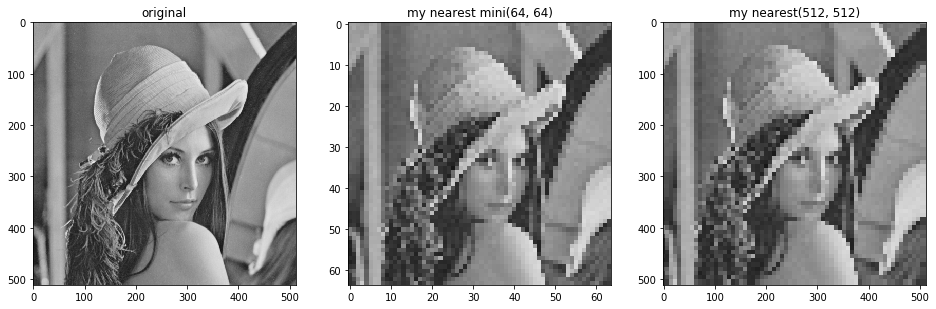

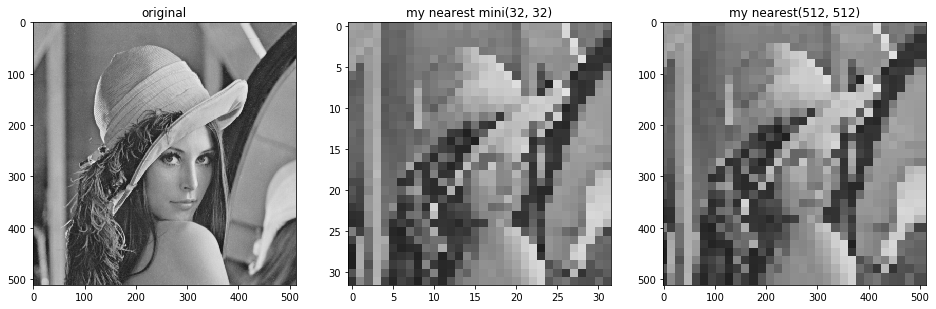

In [8]:
compare_img_nearest(src, 1/2, 2)

compare_img_nearest(src, 1/4, 4)

compare_img_nearest(src, 1/8, 8)

compare_img_nearest(src, 1/16, 16)

bilinear과 비교하면 복구한 image가 깨지는 현상을 많이 볼 수 있습니다. 가까운 pixel을 가져오기 때문에 연속적이지 않고, 그래서 pixel별 경계가 뚜렷하게 보이는 현상을 확인할 수 있습니다.

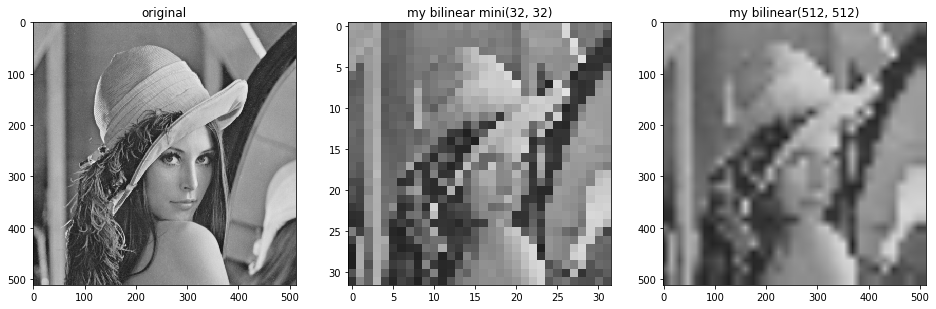

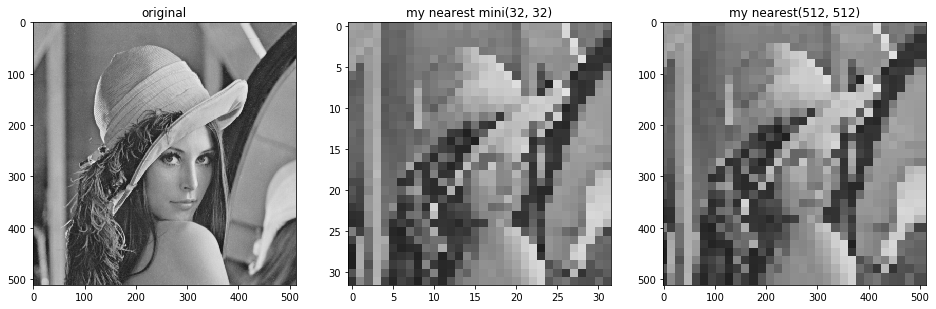

In [9]:
compare_img_bilinear(src, (32,32),(512,512))

compare_img_nearest(src, 1/16, 16)

bilinear이 훨씬 부드러운것을 확인할 수 있습니다.

## 결과

* 원본이미지를 더욱 작게 만들고 복원할수록, 사라지는 값이 많은것을 확인할 수 있습니다.

* nearest_neighbor interpolation보다 bilinear interpolation이 더 부드러운것을 확인할 수 있습니다.